<a href="https://colab.research.google.com/github/Casardo-Chen/wikiart-neural-trasnfer/blob/main/GAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data from Kaggle

In [ ]:
# get data from Kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# make a directory for data
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d bryanb/abstract-art-gallery

 98% 678M/693M [00:04<00:00, 160MB/s]
100% 693M/693M [00:04<00:00, 165MB/s]


In [ ]:
! unzip abstract-art-gallery.zip

Archive:  abstract-art-gallery.zip
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_10.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1000.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1001.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1002.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1003.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1004.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1005.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1006.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1007.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1008.jpg  
  inflating: Abstract_gal

## Load Data from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries and utilities

In [4]:
############################
######## libraries #########
############################
# system
import os
# data science
import numpy as np
import pandas as pd
# visualization
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# pytorch(neural networks)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# vision
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import cv2

!pip install jovian --upgrade --quiet
import jovian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
PROJECT = 'Abstract Art GAN'

## EDA

In [7]:
# explore some art pictures
DATA_DIR = './drive/MyDrive/NN/wikiart-neural-transfer-GAN/Abstract_gallery/'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_gallery']
['Abstract_image_2587.jpg', 'Abstract_image_2529.jpg', 'Abstract_image_2556.jpg', 'Abstract_image_2604.jpg', 'Abstract_image_2483.jpg', 'Abstract_image_2507.jpg', 'Abstract_image_2581.jpg', 'Abstract_image_2554.jpg', 'Abstract_image_2520.jpg', 'Abstract_image_2591.jpg']


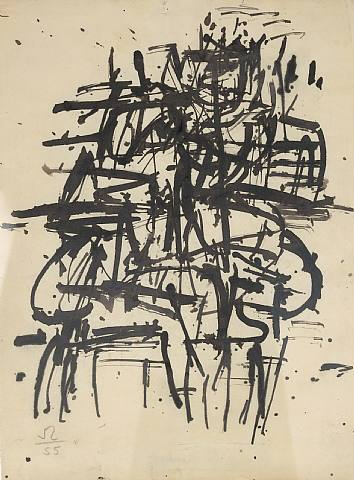

In [8]:
explore = ImageFolder(DATA_DIR)
explore[50][0]

In [9]:
###########################
##### set parameters ######
###########################
image_size = (64,64)      # size of each image
batch_size = 32           # how many images are processing at once
latent_size = 100         # the dimensionality of the random noise vector that is used as input to the generator network
epoch_restore = 150       # epoch times

checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

learning_rate = 0.0002
beta1 = 0.5               # the exponential decay rate for the first moment estimate in the Adam optimizer
epochs = 20

# load data
dataset = ImageFolder(root=DATA_DIR,
                      transform= T.Compose([T.Resize(image_size),
                                            T.ToTensor(),
                                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])           
                      )
dataloader = DataLoader(dataset=dataset, batch_size=batch_size,shuffle=True,num_workers=2)
# prep device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [10]:
# getting a batch from the dataloader 
batch = next(iter(dataloader))

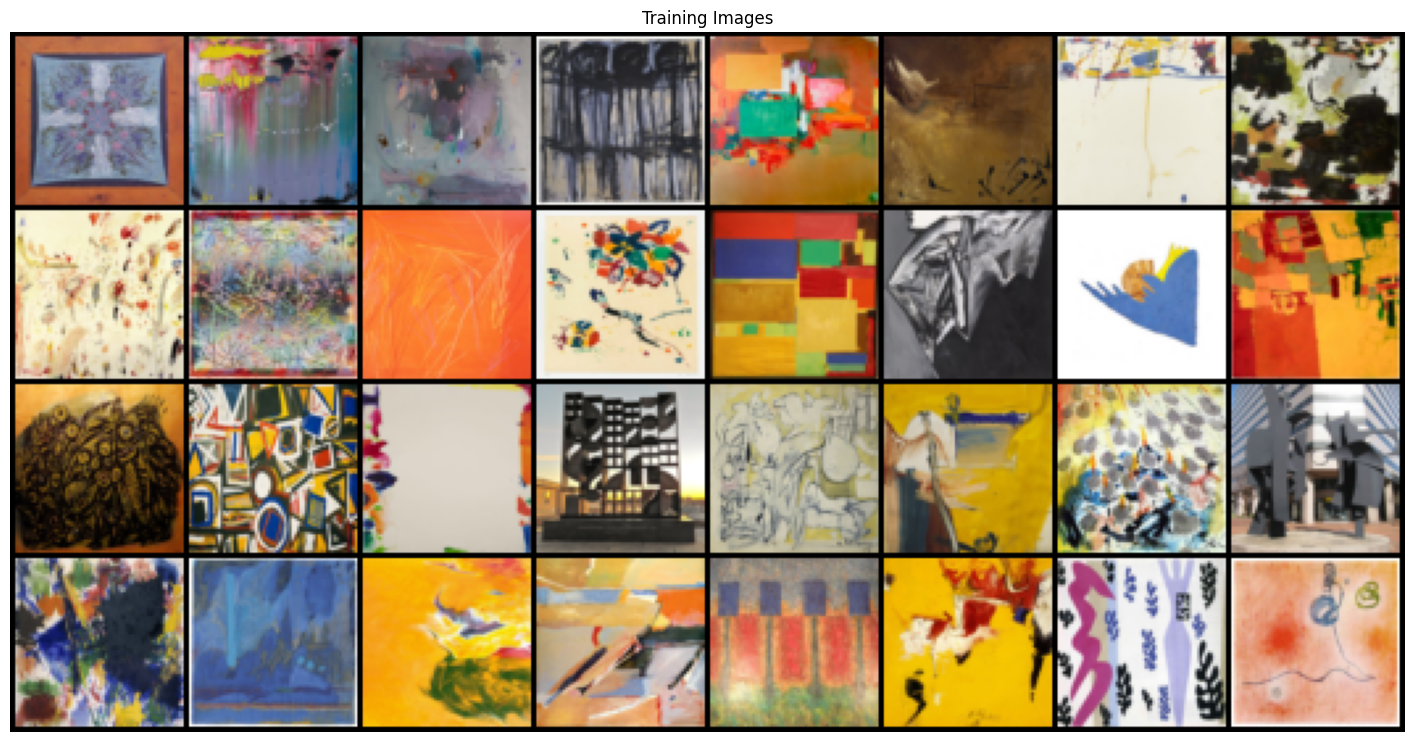

In [11]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")
# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

## DCGAN Model

In [12]:
def init_weights(m):
  class_name = m.__class__.__name__
  if class_name.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif class_name.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [13]:
from pyparsing.helpers import Sequence
############################
######## Generator #########
############################
class Generator(nn.Module):
  def __init__(self, ngpu=0):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      # conv1
      nn.ConvTranspose2d(in_channels=latent_size, out_channels=64*8,kernel_size=4,stride=1,padding=0,bias=False),
      nn.BatchNorm2d(num_features=64*8),
      nn.ReLU(True),
      # conv2
      nn.ConvTranspose2d(in_channels=64*8, out_channels=64*4,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*4),
      nn.ReLU(True),
      # conv3
      nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*2),
      nn.ReLU(True),
      # conv4
      nn.ConvTranspose2d(in_channels=64*2, out_channels=64,kernel_size=4,stride=1,padding=0,bias=False),
      nn.BatchNorm2d(num_features=64),
      nn.ReLU(True),
      # conv 5
      nn.ConvTranspose2d(in_channels=64, out_channels=3,kernel_size=4,stride=1,padding=0,bias=False),
      nn.Tanh()
    )

  def forward(self, input):
    return self.main(input)



In [14]:
# Create the generator
ngpu=0
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(init_weights)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [16]:
from torch.nn.modules.activation import LeakyReLU
class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator,self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # conv1: input 3*64*64; output: 64*32*32 [32=(64-4+2)/2+1]
      nn.Conv2d(in_channels=3, out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
      nn.LeakyReLU(0.2,True),
      # conv2: input 64*32*32; output: 128*16*16 [32=(32-4+2)/2+1]
      nn.Conv2d(in_channels=64, out_channels=64*2,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*2),
      nn.LeakyReLU(0.2,True),
      # conv3: input 128*16*16; output: 256*8*8
      nn.Conv2d(in_channels=64*2, out_channels=64*4,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*4),
      nn.LeakyReLU(0.2,True),
      # conv4: input 256*8*8; output: 512*4*4
      nn.ConvTranspose2d(in_channels=64*4, out_channels=64*8,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*8),
      nn.LeakyReLU(0.2,True),
      # conv5: input 512*4*4
      nn.ConvTranspose2d(in_channels=512, out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)


In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netD.apply(init_weights)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ConvTranspose2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Function and Optimization